<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-the-data:" data-toc-modified-id="Loading-the-data:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the data:</a></span></li><li><span><a href="#Preprocessing-the-training-and-testing-subsets:" data-toc-modified-id="Preprocessing-the-training-and-testing-subsets:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing the training and testing subsets:</a></span></li><li><span><a href="#Transform-data-to-tensor:" data-toc-modified-id="Transform-data-to-tensor:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Transform data to tensor:</a></span><ul class="toc-item"><li><span><a href="#Generator:" data-toc-modified-id="Generator:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generator:</a></span></li><li><span><a href="#convert-data-to-tensors:" data-toc-modified-id="convert-data-to-tensors:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>convert data to tensors:</a></span></li><li><span><a href="#Data-caching:" data-toc-modified-id="Data-caching:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Data caching:</a></span></li><li><span><a href="#Data-augmentation:" data-toc-modified-id="Data-augmentation:-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Data augmentation:</a></span></li><li><span><a href="#Data-visualization:" data-toc-modified-id="Data-visualization:-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Data visualization:</a></span></li></ul></li><li><span><a href="#ML-model:" data-toc-modified-id="ML-model:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ML model:</a></span><ul class="toc-item"><li><span><a href="#Architecture:" data-toc-modified-id="Architecture:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Architecture:</a></span></li><li><span><a href="#Training:" data-toc-modified-id="Training:-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Training:</a></span></li><li><span><a href="#Results:" data-toc-modified-id="Results:-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Results:</a></span></li></ul></li></ul></div>

In [1]:
#notebook in full screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import os

#if we need to read the image from a ZIP file:
import zipfile
import nrrd

#TensorFlow:
import tensorflow as tf
from tensorflow import keras
##check for GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#tqdm (tune the verbose)
from tqdm.keras import TqdmCallback

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14998418912581122775
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15813420478363807420
physical_device_desc: "device: XLA_CPU device"
]


# Loading the data:

In [3]:
#we want couples scan/mask for each scan to be stored in 'dataset' => we will have the first dimension to store the different images,
#next dimension to store all the slices (with a non-zero mask), next dimension to store the pairs scans/masks and last dimension for the 512x512 images
dataset = []

zf = zipfile.ZipFile("../data/STROKE_tr.zip", "r")

for name in zf.namelist():
    if ('angio_input' in name):
        print(name)
        #load input
        file_nrrd = zf.extract(name)
        arrayTmp, options = nrrd.read(file_nrrd, index_order="C")
        print("Shape of inpute: "+str(arrayTmp.shape))
        #load mask
        file_nrrd = zf.extract(name[:-16]+"artery_output.nrrd")
        maskTmp, options = nrrd.read(file_nrrd, index_order="C")
        if(maskTmp[0, 0, 0].shape==(3,)):
            print("Warning: Mask for image "+name[10: 23]+" has 3 images and part of the scan is visible!")
            #we correct the mask:
            maskTmp=maskTmp[:, :, :, 0]
            maskTmp[:, :100, :]=0
            maskTmp[:, -100:, :]=0
            maskTmp[:, :, :100]=0
            maskTmp[:, :, -100:]=0
            maskTmp[maskTmp==255]=1
            print("After correction we have this values in the mask: "+str(np.unique(maskTmp)))
        if(len(np.unique(maskTmp))==3):#there is a mask with 3 different values
            maskTmp[maskTmp==2]=1#we merge the two classes
        print("Shape of mask: "+str(maskTmp.shape))
        #we only keep the slices with values for the mask:
        sampleImg=[]
        for sliceNbr, maskSlice in enumerate(maskTmp):
            if(1 in maskSlice):
                tmp = np.array([arrayTmp[sliceNbr], maskSlice])
                sampleImg.append(tmp)
        sampleImg=np.array(sampleImg)
        print("We have "+str(sampleImg.shape[0])+" slices with a mask value.")
        dataset.append(sampleImg)
        print("**************************************************")
dataset=np.array(dataset)
print("------------------------------------------------\n\
--------------------------------------------------- End:\n\
Total dataset shape: "+str(dataset.shape))

STROKE_tr/20200104_1850/angio_input.nrrd
Shape of inpute: (828, 512, 512)
After correction we have this values in the mask: [0 1]
Shape of mask: (828, 512, 512)
We have 205 slices with a mask value.
**************************************************
STROKE_tr/20200115_0834/angio_input.nrrd
Shape of inpute: (825, 512, 512)
Shape of mask: (825, 512, 512)
We have 332 slices with a mask value.
**************************************************
STROKE_tr/20200121_0905/angio_input.nrrd
Shape of inpute: (763, 512, 512)
Shape of mask: (763, 512, 512)
We have 296 slices with a mask value.
**************************************************
STROKE_tr/20200127_0942/angio_input.nrrd
Shape of inpute: (882, 512, 512)
Shape of mask: (882, 512, 512)
We have 308 slices with a mask value.
**************************************************
STROKE_tr/20200131_1631/angio_input.nrrd
Shape of inpute: (886, 512, 512)
Shape of mask: (886, 512, 512)
We have 249 slices with a mask value.
*************************

# Preprocessing the training and testing subsets:

In [4]:
# Select training and testing subsets (we have 5 images so 4 for training and 1 for testing)
np.random.shuffle(dataset)

In [5]:
train_dataset = dataset[:-1]
train_dataset_f = train_dataset[0]#so, of shape (#slice, 2 ,512 ,512)
#append the remaining images of the training set:
for img in train_dataset[1:]:
    train_dataset_f=np.append(train_dataset_f, img, axis=0)
train_dataset = train_dataset_f
print("Shape of training dataset: "+str(train_dataset.shape))
NUM_TRAIN_SAMPLES = train_dataset.shape[0]
test_dataset = dataset[-1]
print("Shape of testing dataset: "+str(test_dataset.shape))
NUM_TEST_SAMPLES = test_dataset.shape[0]

Shape of training dataset: (1141, 2, 512, 512)
Shape of testing dataset: (249, 2, 512, 512)


In [6]:
#split input/mask:
train_inputs = train_dataset[:, 0]
train_masks = train_dataset[:, 1]

test_inputs = test_dataset[:, 0]
test_masks = test_dataset[:, 1]

print("All different values in train masks: "+str(np.unique(train_masks)))
print("All different values in test masks: "+str(np.unique(test_masks)))

All different values in train masks: [0 1]
All different values in test masks: [0 1]


In [7]:
def sigmoid(x, slope, shift):#slope between 0 and inf
    return 1/(1+np.exp(-slope*(x-shift)))

def rescaling(x):
    return (sigmoid(x, 1/10, -25)+sigmoid(x, 1/10, 530)+sigmoid(x, 1/90, 280))/3

In [8]:
print("Rescaling ...")
normalized_train_inputs=rescaling(train_inputs)
normalized_test_inputs=rescaling(test_inputs)
#####################Changing shape of inputs/outputs to 512x512x1
print("Reshaping ...")
normalized_train_inputs = np.expand_dims(normalized_train_inputs, axis=-1)
train_masks = np.expand_dims(train_masks, axis=-1)
normalized_test_inputs = np.expand_dims(normalized_test_inputs, axis=-1)
test_masks = np.expand_dims(test_masks, axis=-1)
print("#####################")
print("Shape of training inputs: "+str(normalized_train_inputs.shape))
print("Shape of training masks: "+str(train_masks.shape))
print("---")
print("Shape of testing inputs: "+str(normalized_test_inputs.shape))
print("Shape of testing masks: "+str(test_masks.shape))

Rescaling ...
Reshaping ...
#####################
Shape of training inputs: (1141, 512, 512, 1)
Shape of training masks: (1141, 512, 512, 1)
---
Shape of testing inputs: (249, 512, 512, 1)
Shape of testing masks: (249, 512, 512, 1)


In [10]:
#save data
np.save('preprocessed_numpy_arrays/normalized_train_inputs.npy', normalized_train_inputs)
np.save('preprocessed_numpy_arrays/train_masks.npy', train_masks)
np.save('preprocessed_numpy_arrays/normalized_test_inputs.npy', normalized_test_inputs)
np.save('preprocessed_numpy_arrays/test_masks.npy', test_masks)

In [18]:
#load data:
normalized_train_inputs = np.load('preprocessed_numpy_arrays/normalized_train_inputs.npy')
train_masks = np.load('preprocessed_numpy_arrays/train_masks.npy')
normalized_test_inputs = np.load('preprocessed_numpy_arrays/normalized_test_inputs.npy')
test_masks = np.load('preprocessed_numpy_arrays/test_masks.npy')
NUM_TRAIN_SAMPLES=normalized_train_inputs.shape[0]
NUM_TEST_SAMPLES=normalized_test_inputs.shape[0]

# Transform data to tensor:

## Generator:

In [ ]:
DEPTH_SAMPLES = 1 #i.e. our 3rd dim deepth
JUMP_LENGTH = 1 #i.e. the "space" between slices

In [ ]:
def gen_train():
    index = np.arange(0, NUM_TRAIN_SAMPLES-DEPTH_SAMPLES+1, JUMP_LENGTH)
    np.random.shuffle(index)
    for i in index:
        if(DEPTH_SAMPLES==1):
            yield(normalized_train_inputs[i], train_masks[i])
        else:
            yield(normalized_train_inputs[i: i+DEPTH_SAMPLES-1], train_masks[i: i+DEPTH_SAMPLES-1])
            
def gen_test():
    index = np.arange(0, NUM_TEST_SAMPLES-DEPTH_SAMPLES+1, JUMP_LENGTH)
    np.random.shuffle(index)
    for i in index:
        if(DEPTH_SAMPLES==1):
            yield(normalized_test_inputs[i], test_masks[i])
        else:
            yield(normalized_test_inputs[i: i+DEPTH_SAMPLES-1], test_masks[i: i+DEPTH_SAMPLES-1])

## convert data to tensors:

In [19]:
#transform our scans/masks to tensors:
train_dataset = tf.data.Dataset.from_generator(gen_train, (tf.float64, tf.int16))
test_dataset = tf.data.Dataset.from_generator(gen_test, (tf.float64, tf.int16))

In [ ]:
#use one_shot_iterator ?

## Data caching:

In [20]:
BATCH_SIZE=8#i.e. nbr of inputs that are pull at a time
BUFFER_SIZE=25#i.e. size of the buffer from which next random input is selected

In [21]:
train_dataset=train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()#cache(): put data in special cache; shuffle(): for randomness; batch: nbr of image fetched in same time
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)#prefetch: preload data so that loading new data is not a bottleneck
test_dataset=test_dataset.batch(BATCH_SIZE)

## Data augmentation:

In [22]:
#pour le moment je vais rester avec ces données mais il est possible d'augmenter facilement le jeu de données juste en faisant des rotations par example

## Data visualization:

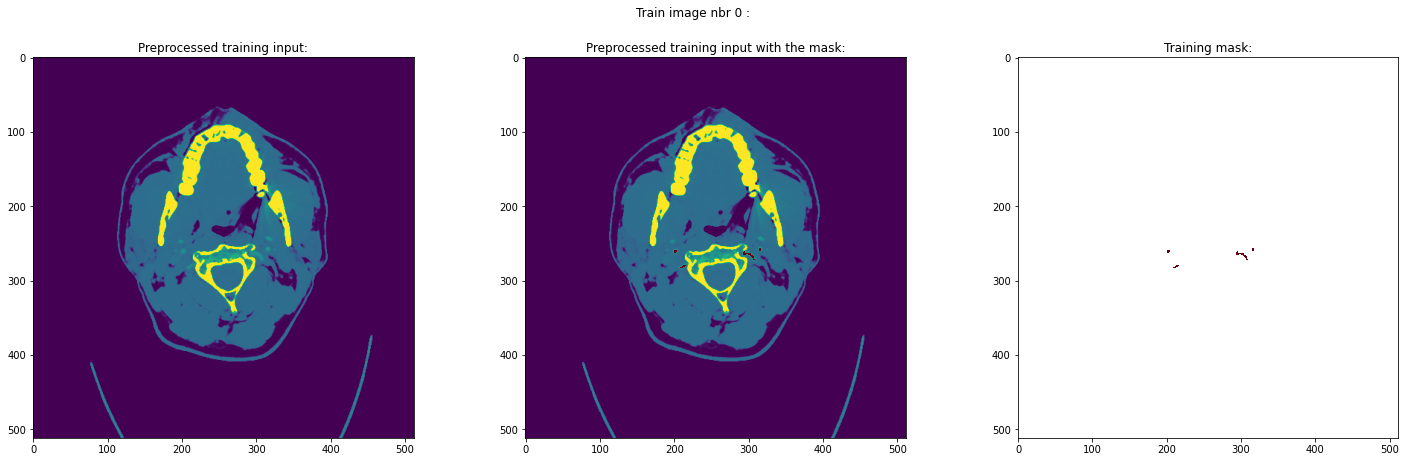

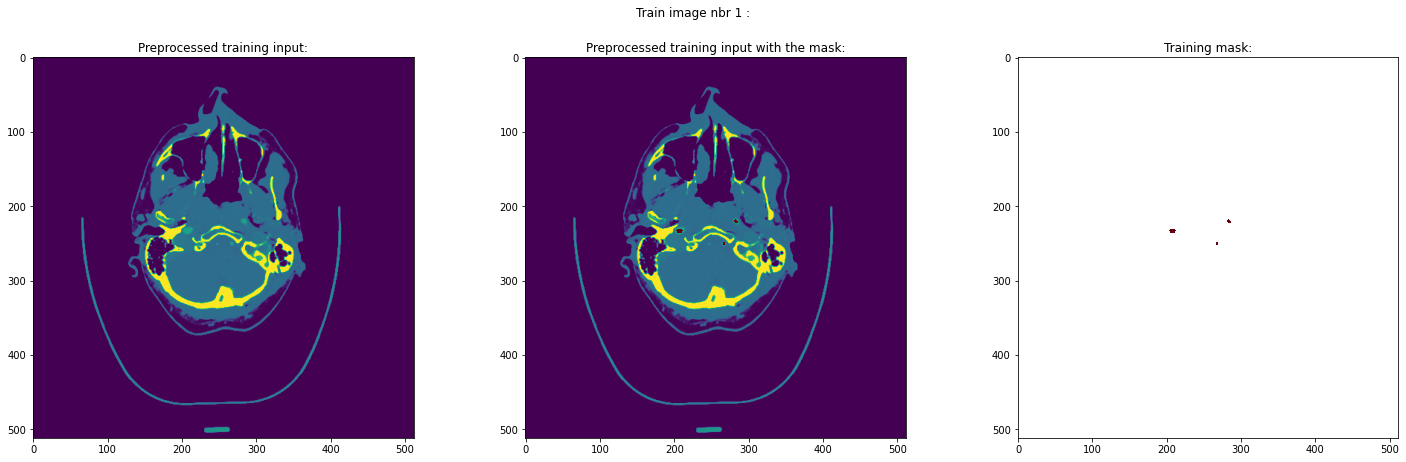

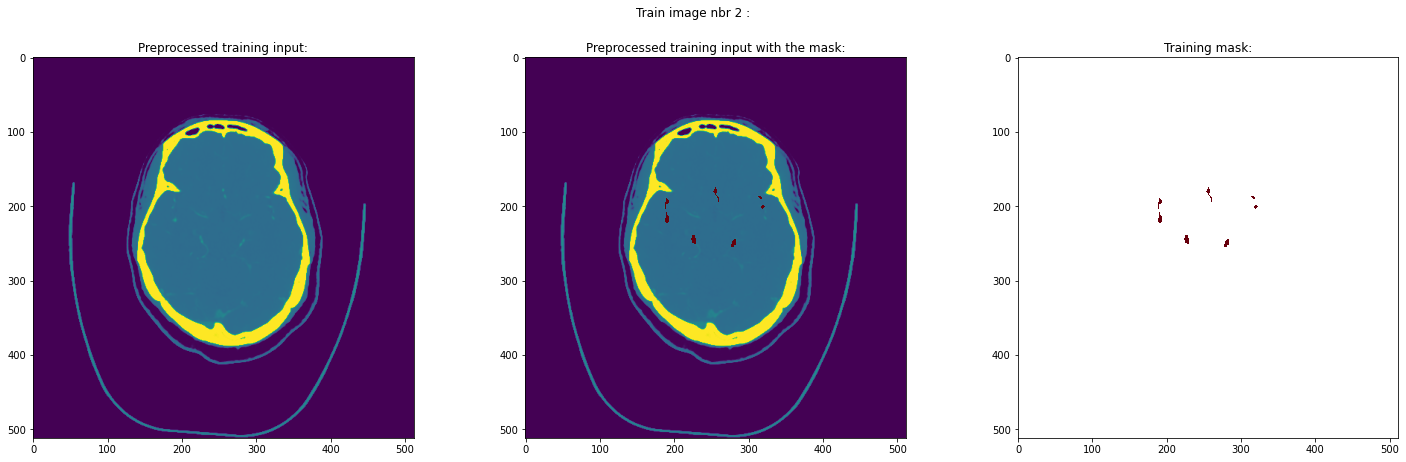

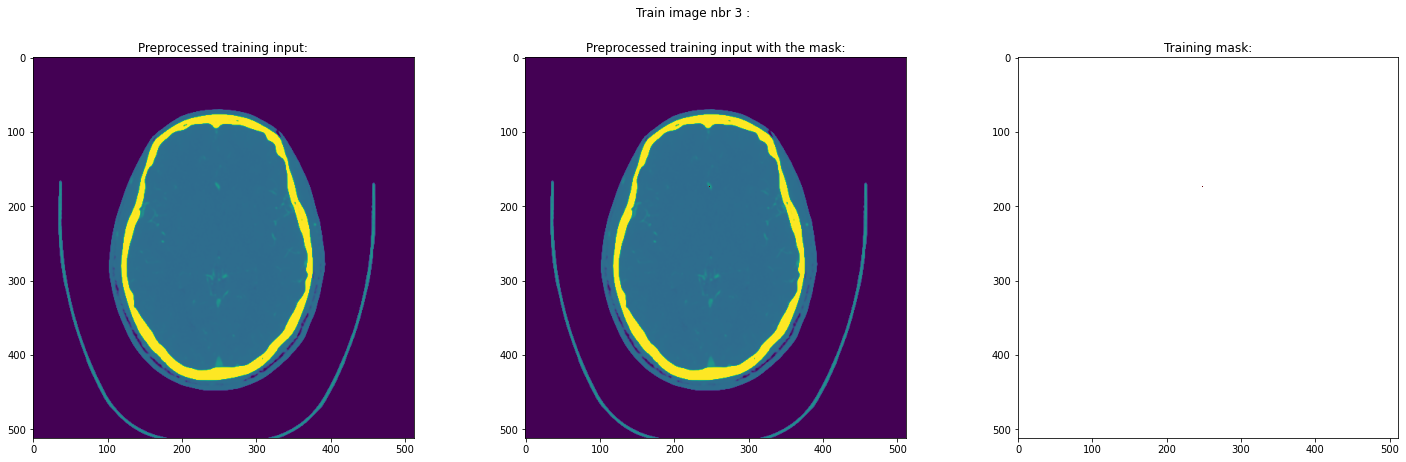

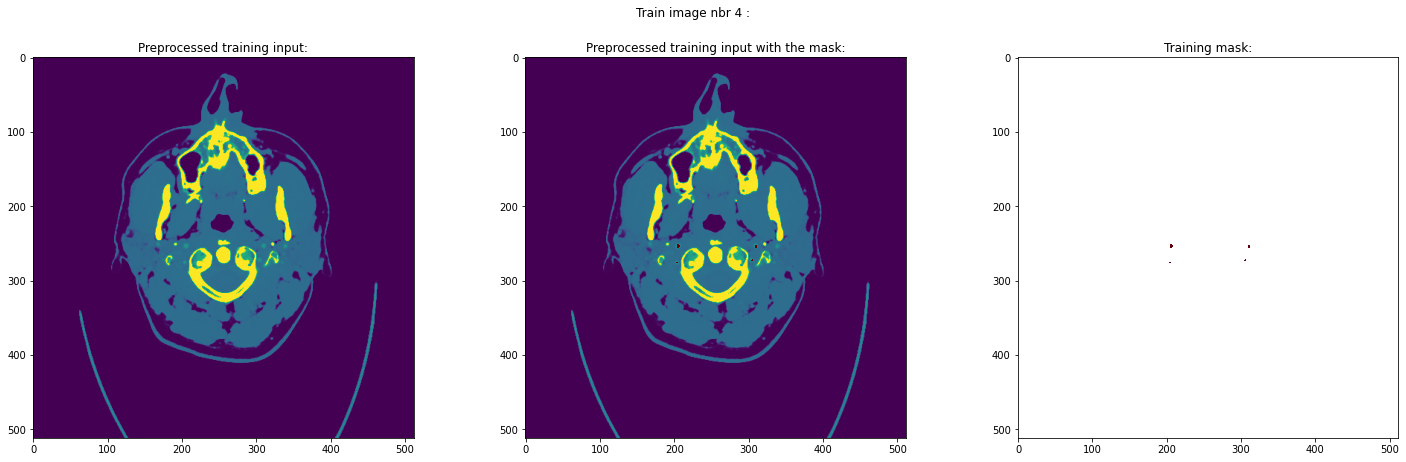

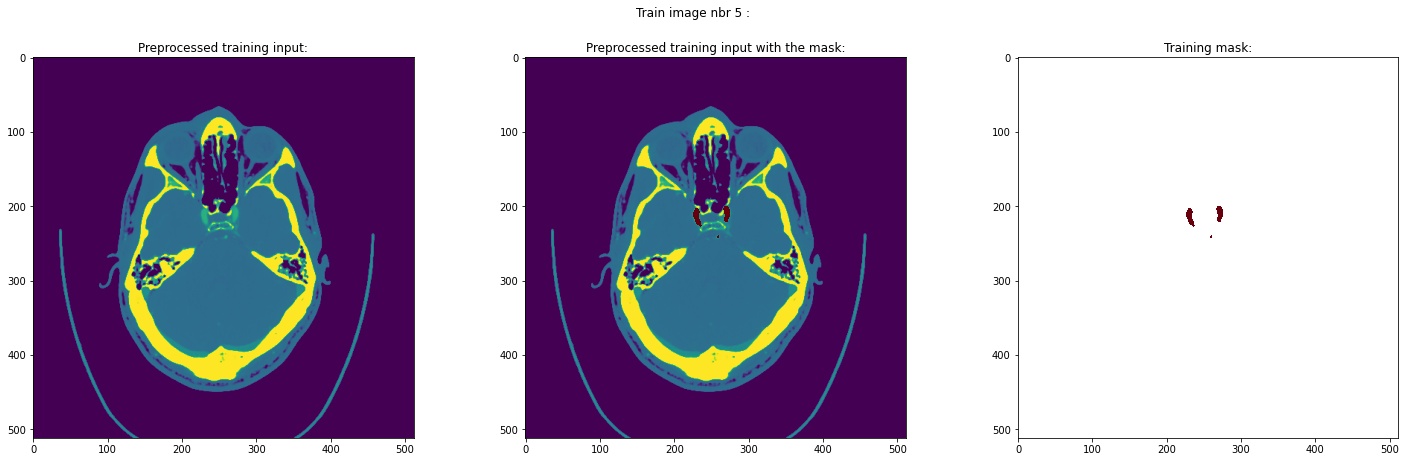

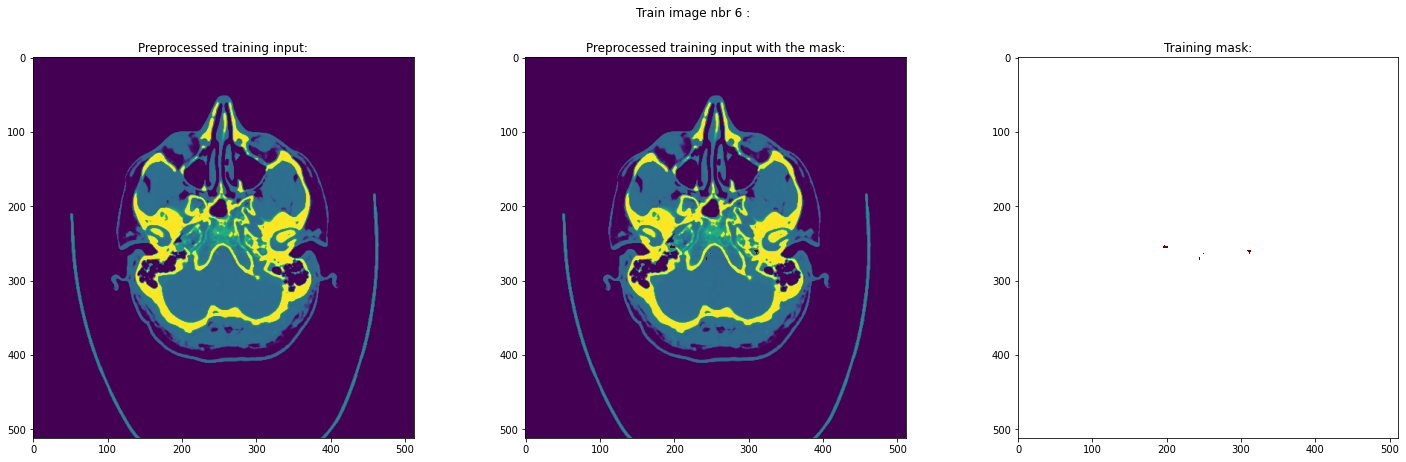

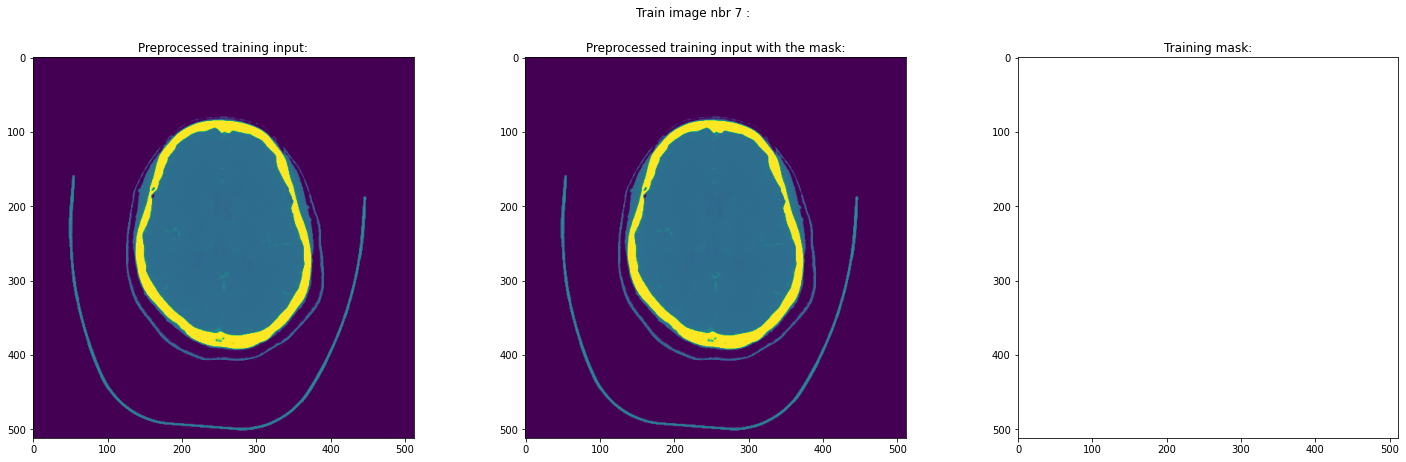

In [9]:
my_norm = matplotlib.colors.Normalize(vmin=0.999, vmax=1, clip=False)

for imgs, masks in train_dataset.take(1):#take one batch
    imgs, masks =imgs.numpy(), masks.numpy()
    for index, im in enumerate(imgs):
        im = im[:, :, 0]
        ma = masks[index][:, :, 0]
        transparent_ma = np.ma.masked_where(ma < 0.5, ma)
    
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))
        fig.suptitle("Train image nbr "+str(index)+" :")
        ax1.imshow(im)
        ax1.set_title("Preprocessed training input:")
        ax2.imshow(im)
        ax2.imshow(transparent_ma, cmap="Reds", norm=my_norm)
        ax2.set_title("Preprocessed training input with the mask:")
        ax3.imshow(transparent_ma, cmap="Reds", norm=my_norm)
        ax3.set_title("Training mask:")
        plt.show()

# ML model:

## Architecture:

In [10]:
def simple_model():
    inputs = tf.keras.layers.Input(shape=(512, 512, 1))
    
    tmp = inputs
    l1conv1 = tf.keras.layers.Conv2D(32, 4, activation = 'relu', padding='same')(tmp)
    l1conv2 = tf.keras.layers.Conv2D(32, 8, activation = 'relu', padding='same')(l1conv1)
    l1pool = tf.keras.layers.MaxPooling2D((2, 2))(l1conv2)
    #we have a 256x256 image now
    bconv1 = tf.keras.layers.Conv2D(64, 4, activation = 'relu', padding='same')(l1pool)
    bconv2 = tf.keras.layers.Conv2D(64, 8, activation = 'relu', padding='same')(bconv1)
    l1up = tf.keras.layers.UpSampling2D((2,2), interpolation='bilinear')(bconv2)
    l1convTmp = tf.keras.layers.Conv2D(32, 8, activation = 'relu', padding='same')(l1up)
    #we have a 512x512 image now
    concat1 = tf.keras.layers.concatenate([l1conv2, l1convTmp])
    l1conv1u = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding='same')(concat1)
    l1conv2u = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding='same')(l1conv1u)
    lastConv = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding='same')(l1conv2u)
    p = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(lastConv)
    
    return tf.keras.Model(inputs = inputs, outputs = p)

In [11]:
model = simple_model()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),#I want to try with F1 score
              metrics=['accuracy'])#tf.keras.metrics.Recall()])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 512, 512, 32) 544         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 512, 512, 32) 65568       conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_10[0][0]                  
_______________________________________________________________________________________

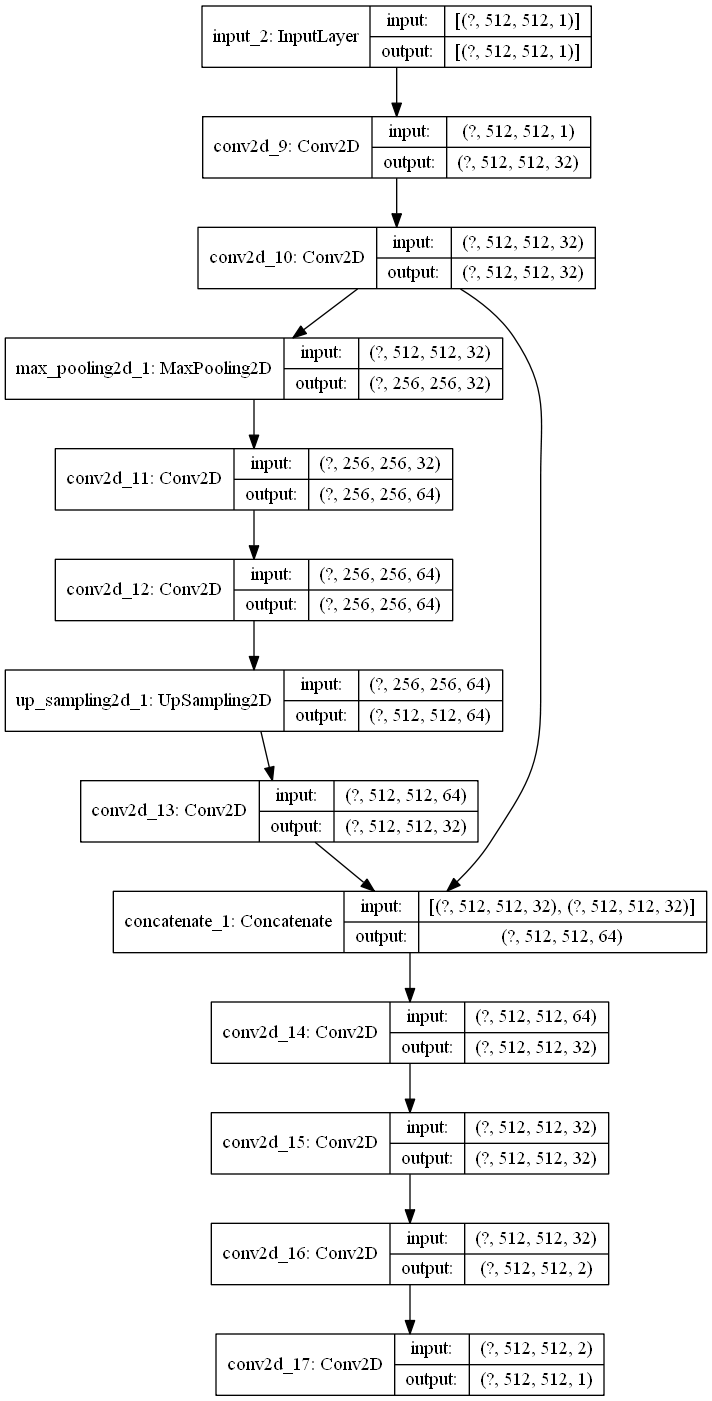

In [13]:
tf.keras.utils.plot_model(model, to_file='architectures_models/simple_model1.png', show_shapes=True)

## Training:

In [14]:
EPOCHS=10
STEPS_PER_EPOCH = NUM_TRAIN_SAMPLES // BATCH_SIZE
VALIDATION_STEPS = NUM_TEST_SAMPLES // BATCH_SIZE // 5
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('simple_model1_best_params.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [15]:
model_history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=test_dataset,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)])#callbacks=[model_checkpoint],
#history = model.fit(normalized_train_inputs, train_masks, epochs=1, validation_data=(normalized_test_inputs, test_masks), callbacks=[TqdmCallback(verbose=1)])#watch out inputs are tuples not np.array

In [16]:
# Save the entire model as a SavedModel:
model.save('saved_model/simple_model1_10EPOCH') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/simple_model1_10EPOCH\assets


In [17]:
#load the trained model:
model = tf.keras.models.load_model('saved_model/simple_model1_10EPOCH')

## Results:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


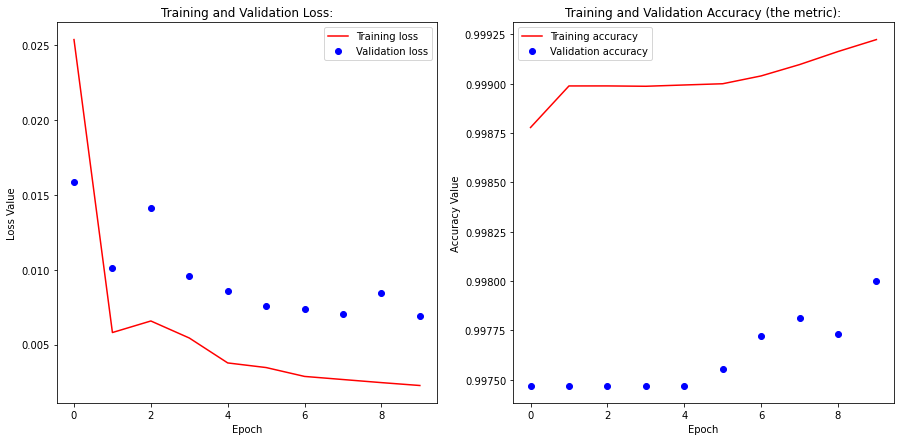

In [18]:
print(model_history.history.keys())

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
#loss:
ax1.plot(epochs, loss, 'r', label='Training loss')
ax1.plot(epochs, val_loss, 'bo', label='Validation loss')
ax1.set_title('Training and Validation Loss:')
ax1.set(xlabel='Epoch', ylabel='Loss Value')#, ylim=[0,1])
ax1.legend()
#metric: accuracy
ax2.plot(epochs, acc, 'r', label='Training accuracy')
ax2.plot(epochs, val_acc, 'bo', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy (the metric):')
ax2.set(xlabel='Epoch', ylabel='Accuracy Value')#, ylim=[0,1])
ax2.legend()
plt.show()

1.7821588e-19
0.89434296


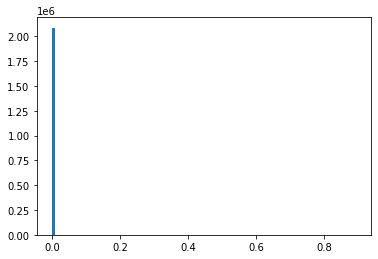

In [19]:
for imgs, masks in test_dataset.take(1):#take one batch
    predicted_masks = model.predict(imgs)
    t = predicted_masks.flatten()
    plt.hist(t, bins=100)
    print(t.min())
    print(t.max())

In [20]:
def predict_masks(batch_inputs, model, threshold):
    pred_masks = model.predict(batch_inputs)
    pred_masks = pred_masks[:, :, :, 0]
    pred_masks[pred_masks<threshold] = 0
    pred_masks[pred_masks>=threshold] = 1
    
    return pred_masks

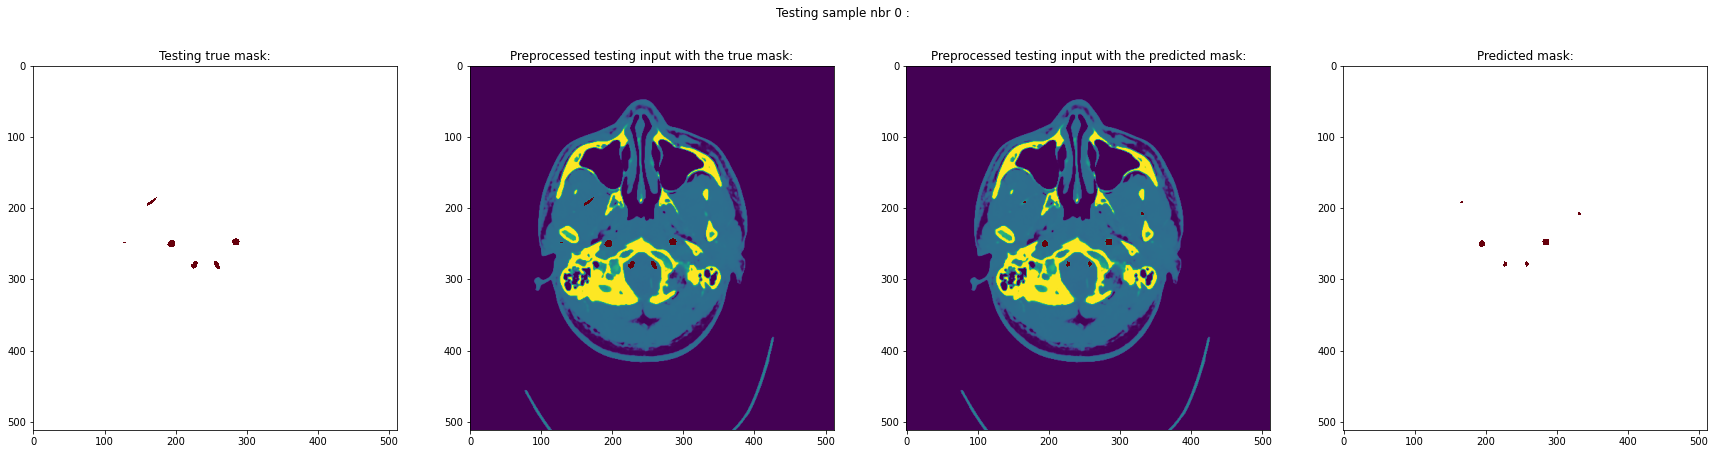

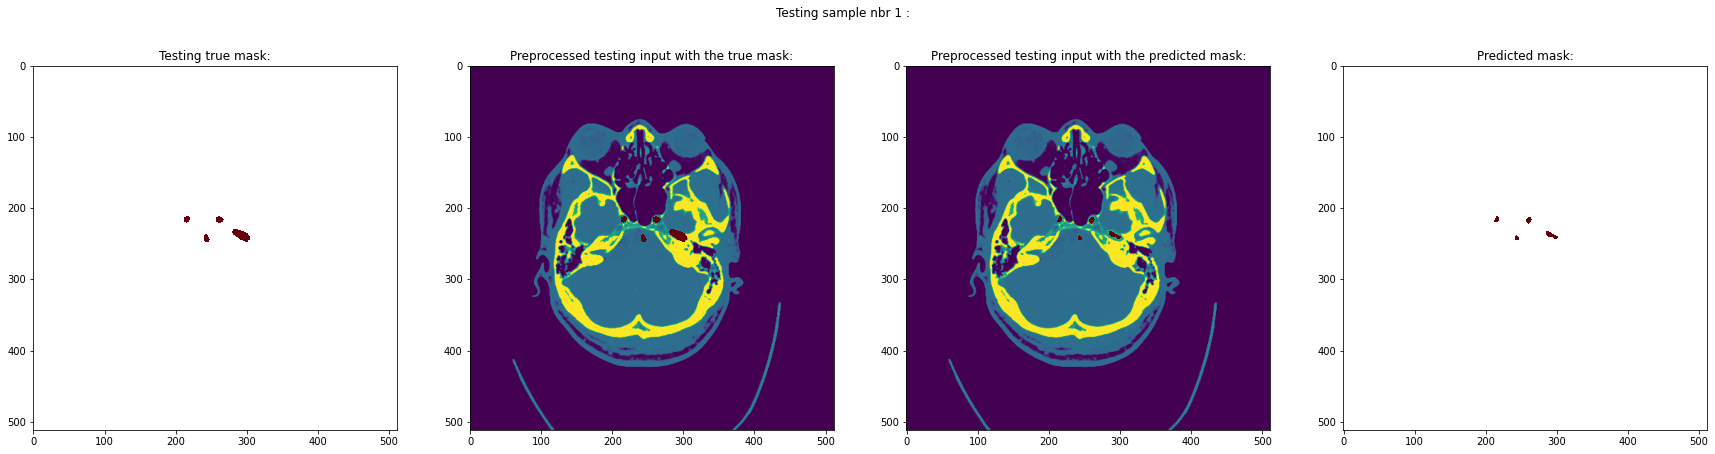

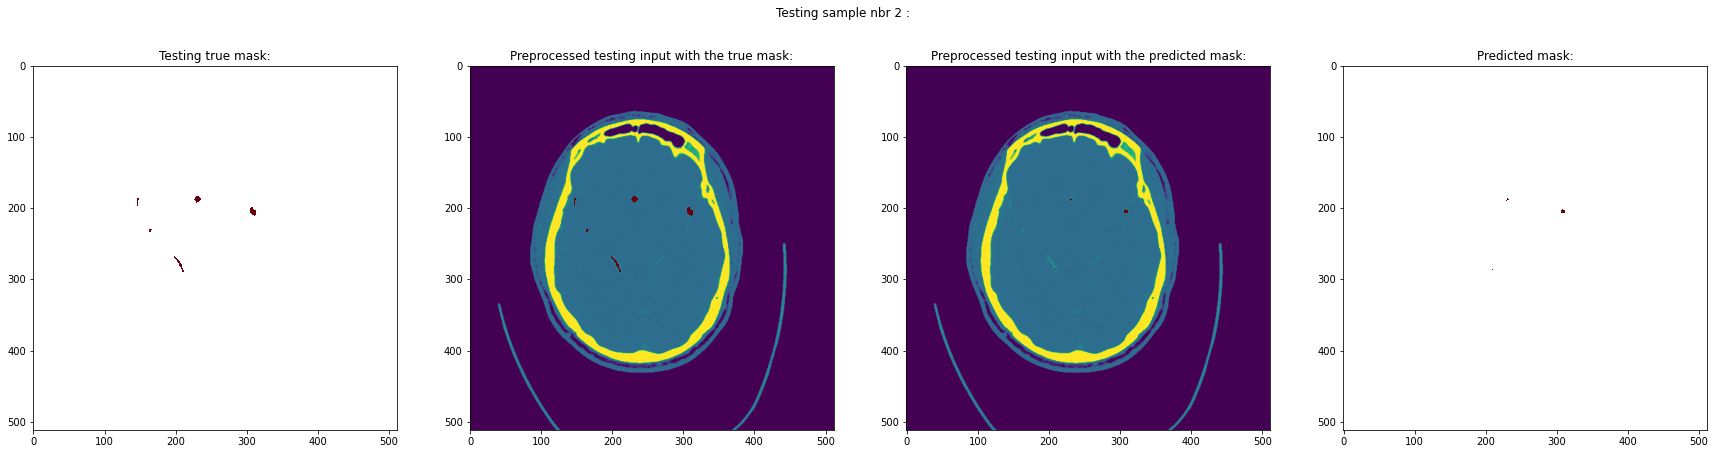

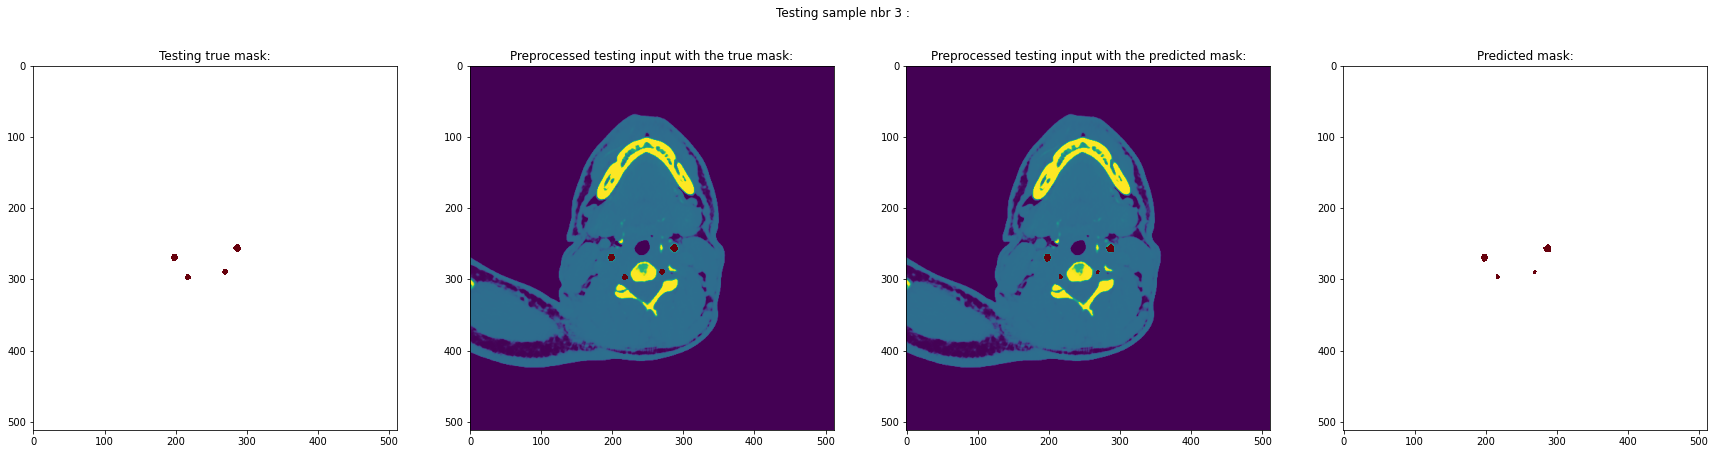

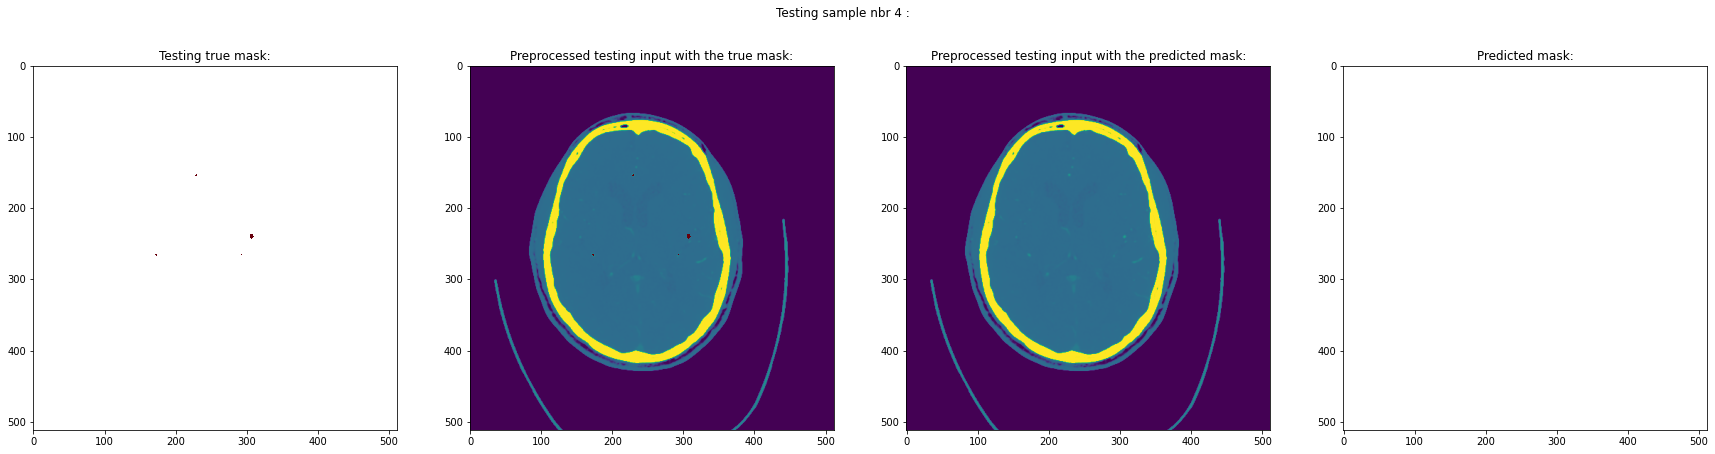

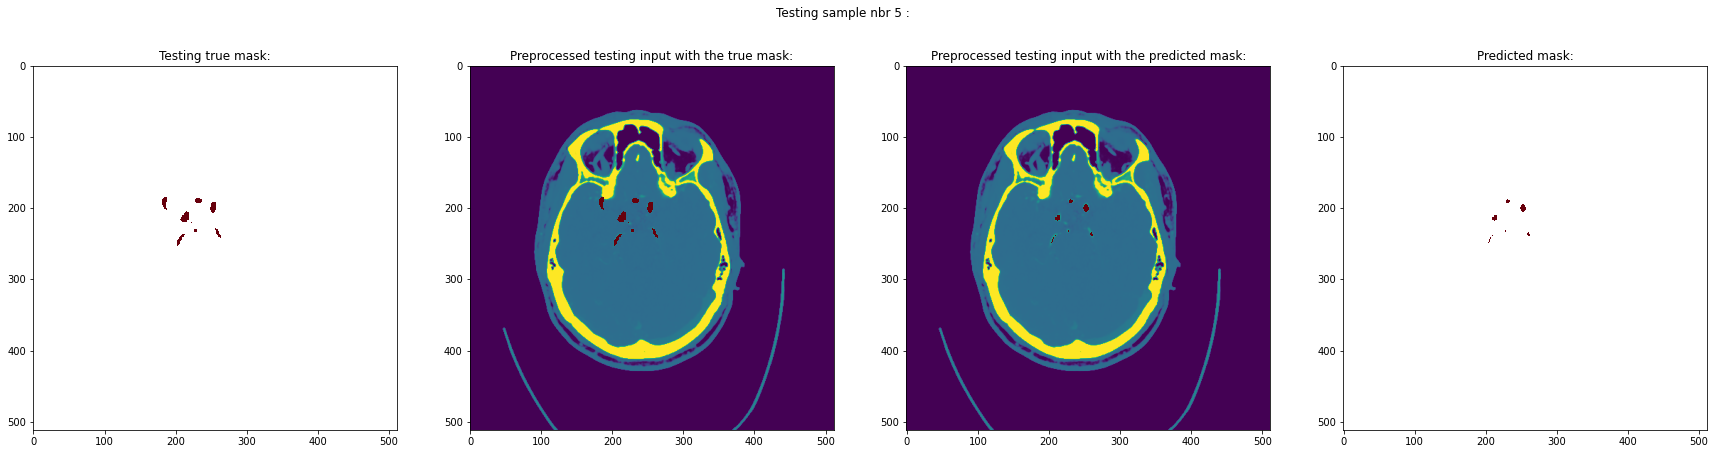

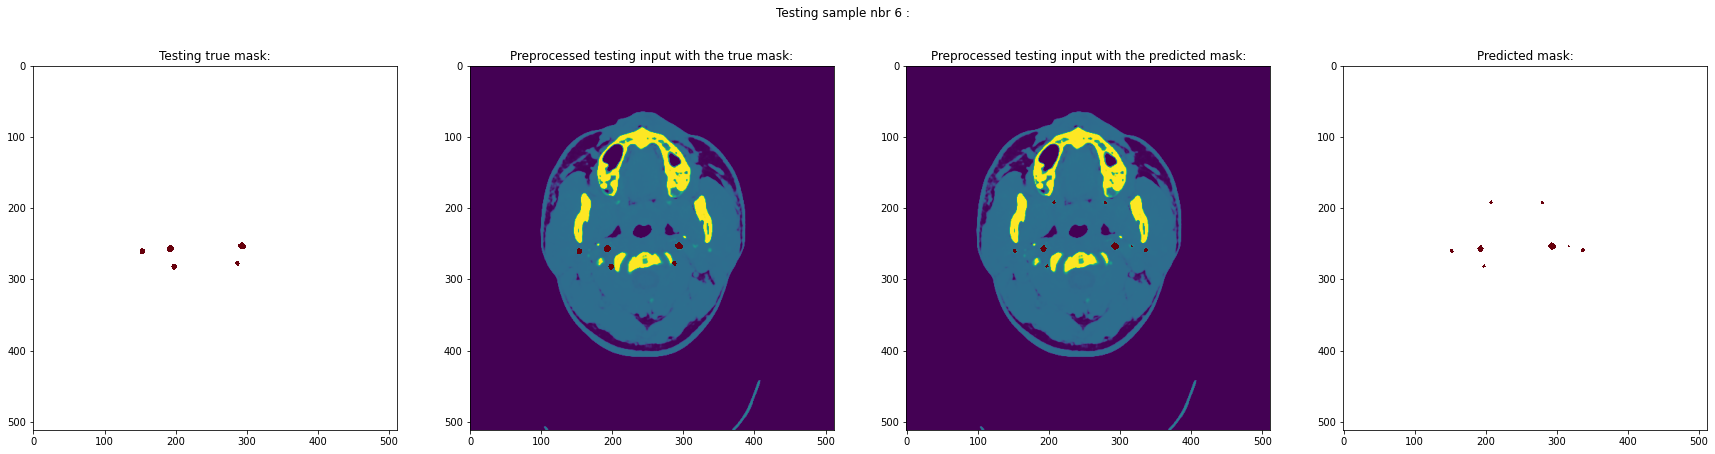

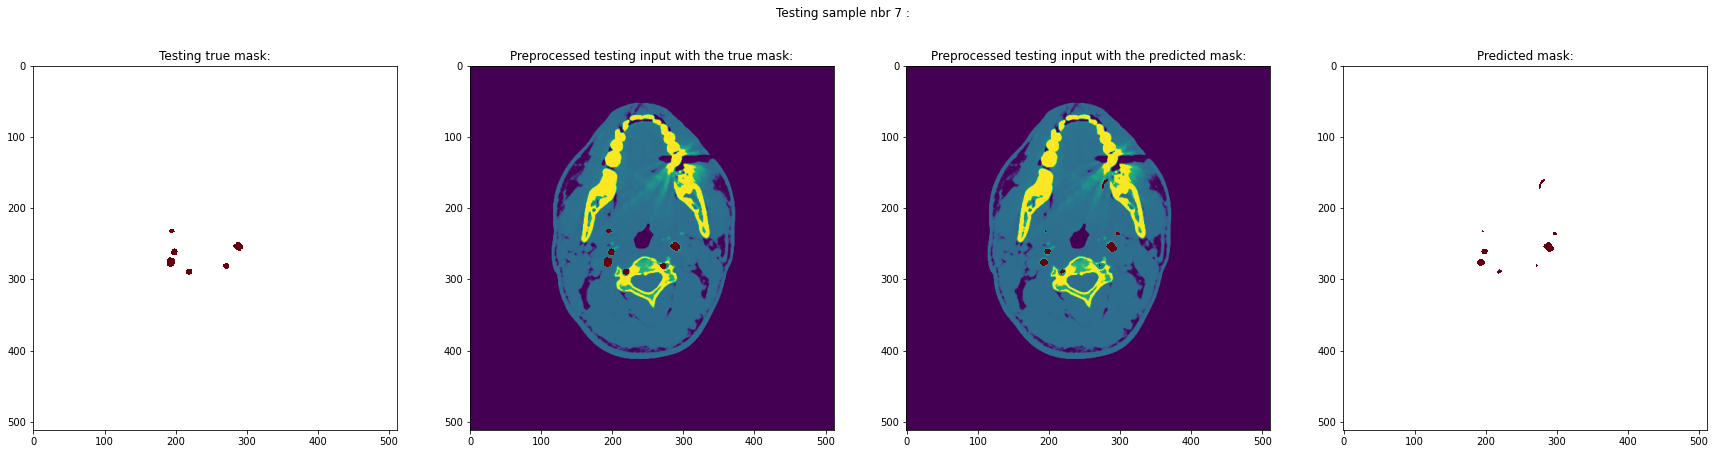

In [22]:
THRESHOLD = 0.2

my_norm = matplotlib.colors.Normalize(vmin=0.999, vmax=1, clip=False)

for imgs, masks in test_dataset.take(1):#take one batch
    predictions = predict_masks(imgs, model, THRESHOLD)
    transparent_predictions = np.ma.masked_where(predictions < 0.5, predictions)
    imgs, masks =imgs.numpy(), masks.numpy()
    for index, im in enumerate(imgs):
        im = im[:, :, 0]
        ma = masks[index][:, :, 0]
        transparent_ma = np.ma.masked_where(ma < 0.5, ma)
    
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 7))
        fig.suptitle("Testing sample nbr "+str(index)+" :")
        ax1.set_title("Testing true mask:")
        ax1.imshow(transparent_ma, cmap="Reds", norm=my_norm)
        ax2.set_title("Preprocessed testing input with the true mask:")
        ax2.imshow(im)
        ax2.imshow(transparent_ma, cmap="Reds", norm=my_norm)
        ax3.set_title("Preprocessed testing input with the predicted mask:")
        ax3.imshow(im)
        ax3.imshow(transparent_predictions[index], cmap="Reds", norm=my_norm)
        ax4.set_title("Predicted mask:")
        ax4.imshow(transparent_predictions[index], cmap="Reds", norm=my_norm)
        plt.show()

- The results are good but we need a threshold lower than 0.5 :(.  
- We can try to give more importance to underrepresented classes (i.e. class '1').
- sometimes the loss optimization seems to converge, sometimes not.